线性模型可以看作是单层的神经网络


### 基础优化算法

1. 梯度下降
   - 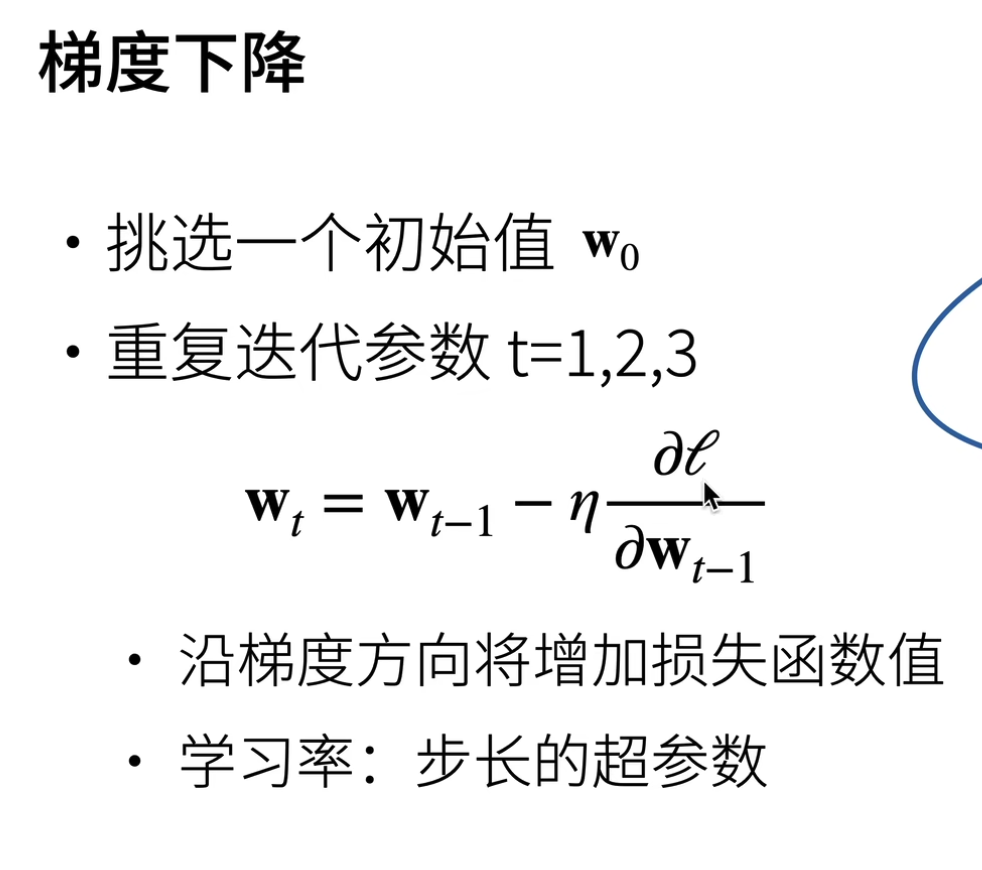
   - 负梯度是下降最快的方向
   - 超参数：学习率的选择
     - 太大，出现震荡，跳过最优解
     - 太小，浪费计算成本

2. 小批量随机梯度下降 SGD
   - 减少计算成本
   - 随机选择b个样本，估计整个样本集的近似损失。
   - 超参数：b
     - 太大：计算内存消耗增加
     - 太小：不适合并行计算，最大利用计算资源

### 从0开始实现线性回归

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [5]:
# 人造数据 y = Xw + b + e w=[2, -3.4] b=4.2

def synthetic_data(w, b, num_examples):
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.0526, 0.7526]) 
label: tensor([3.7497])


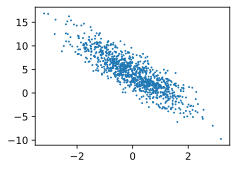

In [10]:
# detach(): 从计算图中分离张量，防止梯度更新。
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

In [13]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机读取样本
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for x, y in data_iter(batch_size, features, labels):
    print(x, '\n', y)
    break
    

tensor([[ 0.5332,  0.2762],
        [ 0.3360,  1.6250],
        [ 0.2401, -0.0224],
        [-0.0167, -0.6819],
        [-1.9812,  0.3238],
        [ 0.4813, -0.8625],
        [ 0.2240,  1.2806],
        [ 1.0672, -0.0137],
        [ 0.1975, -1.3708],
        [-0.8768, -0.7925]]) 
 tensor([[ 4.3433],
        [-0.6413],
        [ 4.7648],
        [ 6.4967],
        [-0.8559],
        [ 8.1015],
        [ 0.2920],
        [ 6.3767],
        [ 9.2466],
        [ 5.1450]])


In [28]:
# 定义模型初始化

w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [15]:
# 定义线性模型

def linreg(x, w, b):
    return torch.matmul(x, w) + b

In [16]:
# 损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [17]:
# 定义优化算法
# with 上下文管理器，简化代码，确保在代码块结束时自动清理资源 或 执行退出操作。常见的场景：文件操作，线程锁
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [29]:
# train
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, features, labels):
        l = loss(net(x, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039963
epoch 2, loss 0.000146
epoch 3, loss 0.000049
epoch 4, loss 0.000048
epoch 5, loss 0.000048
epoch 6, loss 0.000048
epoch 7, loss 0.000048
epoch 8, loss 0.000048
epoch 9, loss 0.000048
epoch 10, loss 0.000048


In [30]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002,  0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([3.4332e-05], grad_fn=<RsubBackward1>)


In [31]:
# 简单处理
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l


In [32]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [33]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 0.0716, -2.0046],
         [ 0.7102,  1.5316],
         [-1.4767, -1.2045],
         [ 2.4178, -1.7715],
         [-1.1480,  0.4173],
         [-0.5440,  0.2767],
         [ 1.5952,  1.1059],
         [ 0.6529, -0.7626],
         [ 0.0805, -2.2427],
         [ 0.4566,  0.0181]]),
 tensor([[11.1599],
         [ 0.4192],
         [ 5.3552],
         [15.0517],
         [ 0.4915],
         [ 2.1673],
         [ 3.6236],
         [ 8.1110],
         [11.9835],
         [ 5.0369]])]

In [34]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [35]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [36]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [37]:
num_epochs = 3
for epoch in range(num_epochs):
    for x, y in data_iter:
        l = loss(net(x), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000217
epoch 2, loss 0.000098
epoch 3, loss 0.000099


loss 选用平方损失而不用绝对差值的原因：绝对差值在零点处不可导，不能求梯度

损失平均的主要原因也是归一化，使得不同的batch lr 可以用一样的，而且也比较好调整其大小

lr 设置： 1）adam 对学习率不稳定的方法 2）好的初始化

batchsize 越小越好，原因是引入的噪音会比较大，泛化性会更好一些

